In [16]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import numpy as np
from graphgym.custom_graphgym.loader.protein import ProteinDataset

In [2]:
# %connect_info
%qtconsole

Import data from csv fies

In [26]:

# dataset = ProteinDataset("../data/yeast-ORBI", numeric_columns=['protein probability'], label_column=None)
# dataset = ProteinBatchDataset("../data/yeast-LCQ", numeric_params=['protein probability'])
# dataset = ProteinBatchDataset("../data/yeast-ORBI-mRNA", numeric_params=['protein probability', 'mRNA(M)'])
# dataset = ProteinBatchDataset("../data/yeast-LCQ-mRNA", numeric_params=['protein probability', 'mRNA(M)'])
dataset = ProteinDataset("../../data/single-soft-label", numeric_columns=['protein_probability'], label_column=None)

In [27]:
dataset.x

tensor([[0.8900],
        [0.7001],
        [0.2869],
        ...,
        [0.0000],
        [0.0000],
        [0.0000]])

(array([7.830e+02, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 3.000e+00, 1.600e+01, 2.300e+01, 3.100e+01, 8.500e+01,
        5.600e+01, 6.400e+01, 4.800e+01, 5.500e+01, 5.500e+01, 7.200e+01,
        6.400e+01, 7.300e+01, 6.800e+01, 6.100e+01, 7.900e+01, 7.900e+01,
        6.900e+01, 8.100e+01, 7.400e+01, 7.800e+01, 7.800e+01, 8.800e+01,
        8.400e+01, 9.300e+01, 8.200e+01, 9.000e+01, 1.090e+02, 1.220e+02,
        1.140e+02, 1.160e+02, 1.280e+02, 1.050e+02, 1.150e+02, 1.350e+02,
        1.050e+02, 1.280e+02, 1.330e+02, 1.130e+02, 1.300e+02, 1.210e+02,
        1.660e+02, 1.400e+02, 1.240e+02, 1.280e+02, 1.360e+02, 1.450e+02,
        1.440e+02, 1.430e+02, 1.390e+02, 1.350e+02, 1.550e+02, 1.680e+02,
        1.540e+02, 1.550e+02, 1.530e+02, 1.560e+02, 1.710e+02, 1.700e+02,
        1.590e+02, 1.740e+02, 1.540e+02, 1.690e+02, 1.840e+02, 1.760e+02,
        2.160e+02, 1.820e+02, 1.980e+0

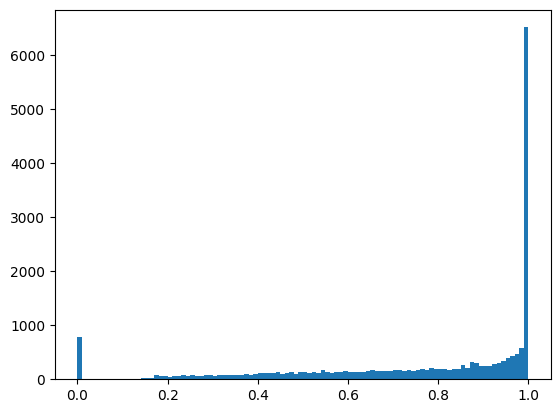

In [28]:
from matplotlib.pyplot import hist

# dataset.y[dataset.train_mask].bincount()
# dataset.y[dataset.val_mask].bincount()
# dataset.y[dataset.test_mask].bincount()
hist(dataset.y, bins=100)

In [29]:
# print(f'Number of nodes: {dataset.num_nodes}')
print(f'Number of node features: {dataset.num_node_features}')
# print(f'Number of edges: {dataset.num_edges}')
print(f'Number of edge features: {dataset.num_edge_features}')
# print(f'Average node degree: {dataset.num_edges / dataset.num_nodes:.2f}')
print(f'Number of training nodes: {dataset.train_mask.sum()}')
# print(f'Training node label rate: {int(dataset.train_mask.sum()) / dataset.num_nodes:.2f}')
# print(f'Validation node label rate: {int(dataset.val_mask.sum()) / dataset.num_nodes:.2f}')
# print(f'Test node label rate: {int(dataset.test_mask.sum()) / dataset.num_nodes:.2f}')
# print(f'Has isolated nodes: {dataset.has_isolated_nodes()}')
# print(f'Has self-loops: {dataset.has_self_loops()}')
# print(f'Is undirected: {dataset.is_undirected()}')

Number of node features: 1
Number of edge features: 0
Number of training nodes: 12256


In [30]:
dataset

ProteinDataset()

In [31]:
from torch.utils.data import DataLoader
import torch
train_dataset = torch.utils.data.TensorDataset(dataset.x[dataset.train_mask], dataset.y[dataset.train_mask].unsqueeze(1))
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = torch.utils.data.TensorDataset(dataset.x[dataset.val_mask], dataset.y[dataset.val_mask].unsqueeze(-1))
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataset = torch.utils.data.TensorDataset(dataset.x[dataset.test_mask], dataset.y[dataset.test_mask].unsqueeze(-1))
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [32]:
import os
from torch import optim, nn, utils, Tensor
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import pytorch_lightning as pl
from torchmetrics.classification import BinaryAUROC, BinaryAccuracy, BinaryF1Score


# define the LightningModule
class MLP(pl.LightningModule):
    def __init__(self, num_features, hidden_channels, num_classes, criterion):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = nn.Linear(num_features, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, hidden_channels)
        self.lin3 = nn.Linear(hidden_channels, num_classes)
        self.criterion = criterion
        self.val_auroc = BinaryAUROC()
        self.test_auroc = BinaryAUROC()
        # self.val_accuracy = BinaryAccuracy()
        # self.test_accuracy = BinaryAccuracy()
        self.val_F1 = BinaryF1Score()
        self.test_F1 = BinaryF1Score()

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = self.lin2(x)
        x = x.relu()
        x = self.lin3(x)
        return x

    def get_auc(self, out, target):
        return self.auroc(out, target)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)  # Perform a single forward pass.

        loss = self.criterion(logits, y)  # Compute the loss solely based on the training nodes.
        values = {"loss": loss}
        self.log_dict(values, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)  # Perform a single forward pass.

        # self.val_accuracy.update(logits[:, 1], y)
        loss = self.criterion(logits, y)  # Compute the loss solely based on the training nodes.
        # self.val_auroc.update(logits, y)
        # self.val_F1.update(logits, y)
        values = {"val_loss": loss}
        self.log_dict(values, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        # self.test_accuracy.update(logits[:, 1], y)
        loss = self.criterion(logits, y)
        # self.test_auroc.update(logits, y)
        # self.test_F1.update(logits, y)
        values = {"test_loss": loss}
        self.log_dict(values, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer



In [33]:
# init the autoencoder
MLP_model = MLP(dataset.num_node_features, 10, 1, criterion = torch.nn.BCEWithLogitsLoss())
# MLP_model = MLP(dataset.num_node_features, 10, 2, criterion = torch.nn.CrossEntropyLoss())

In [34]:
trainer = pl.Trainer(limit_train_batches=100, max_epochs=300, enable_progress_bar = False)
trainer.fit(model=MLP_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type              | Params
-------------------------------------------------
0 | lin1       | Linear            | 20    
1 | lin2       | Linear            | 110   
2 | lin3       | Linear            | 11    
3 | criterion  | BCEWithLogitsLoss | 0     
4 | val_auroc  | BinaryAUROC       | 0     
5 | test_auroc | BinaryAUROC       | 0     
6 | val_F1     | BinaryF1Score     | 0     
7 | test_F1    | BinaryF1Score     | 0     
-------------------------------------------------
141       Trainable params
0         Non-trainable params
141       Total params
0.001     Total estimated model params size (MB)
/Users/cgu3/opt/anaconda3/envs/Grape-Pi/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bo

In [35]:
trainer.test(model=MLP_model, dataloaders=test_dataloader)

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4833141565322876
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/Users/cgu3/opt/anaconda3/envs/Grape-Pi/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


[{'test_loss': 0.4833141565322876}]

In [54]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

Launching TensorBoard...